## Put-Call Parity and Arbitrage

In [1]:
import pandas as pd
import numpy as np

# Load the Excel or CSV file
file_path = 'C:\\Users\\TEJAS\\Downloads\\Put-Call Parity Data.xlsx'  # Update with your file path
data = pd.read_excel(file_path)

# Display the first few rows
print(data.head())

        Date  Spot Price (S)  Strike Price (K)  Call Price ©  Put Price (P)  \
0 2024-11-05          101.65                95         6.800           0.17   
1 2024-11-05          101.65                98         4.225           0.61   
2 2024-11-05          101.65                99         3.475           0.88   
3 2024-11-05          101.65               100         2.785           1.13   
4 2024-11-05          101.65               101         2.160           1.55   

   Risk-Free Rate (r)  Time to Maturity (T)  
0            0.046975              0.035714  
1            0.046975              0.035714  
2            0.046975              0.035714  
3            0.046975              0.035714  
4            0.046975              0.035714  


In [2]:
# Add a column for LHS (C - P)
data['LHS (C - P)'] = data['Call Price ©'] - data['Put Price (P)']

# Add a column for RHS (S - K * exp(-r * T))
data['RHS (S - Ke^(-rt))'] = data['Spot Price (S)'] - data['Strike Price (K)'] * np.exp(-data['Risk-Free Rate (r)'] * data['Time to Maturity (T)'])

# Calculate the deviation (LHS - RHS)
data['Deviation'] = data['LHS (C - P)'] - data['RHS (S - Ke^(-rt))']

# Display the first few rows
print(data[['LHS (C - P)', 'RHS (S - Ke^(-rt))', 'Deviation']])

    LHS (C - P)  RHS (S - Ke^(-rt))  Deviation
0         6.630            6.809246  -0.179246
1         3.615            3.814275  -0.199275
2         2.595            2.815951  -0.220951
3         1.655            1.817627  -0.162627
4         0.610            0.819303  -0.209303
5        -0.385           -0.179020  -0.205980
6        -1.390           -1.177344  -0.212656
7        -2.430           -2.175668  -0.254332
8        -3.410           -3.173991  -0.236009
9        -4.445           -4.172315  -0.272685
10       -5.460           -5.170639  -0.289361
11       -8.495           -8.165610  -0.329390
12      -12.480          -12.158905  -0.321095
13      -28.880          -28.132085  -0.747915


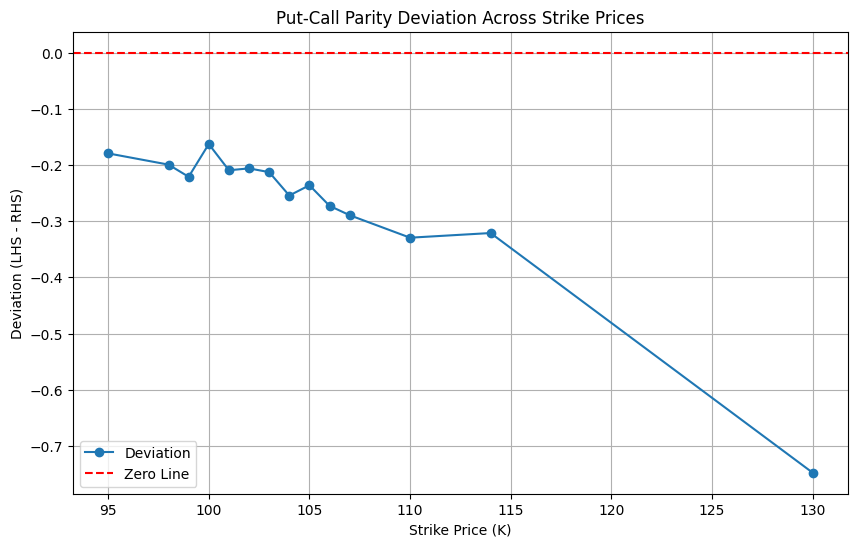

In [3]:
import matplotlib.pyplot as plt

# Plot Deviations
plt.figure(figsize=(10, 6))
plt.plot(data['Strike Price (K)'], data['Deviation'], marker='o', label='Deviation')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.title('Put-Call Parity Deviation Across Strike Prices')
plt.xlabel('Strike Price (K)')
plt.ylabel('Deviation (LHS - RHS)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
output_path = 'C:\\Users\\TEJAS\\Downloads\\Put-Call Parity Python Results.xlsx'
data.to_excel(output_path, index=False)
print(f"Results saved to {output_path}")

Results saved to C:\Users\TEJAS\Downloads\Put-Call Parity Python Results.xlsx


In [10]:
import pandas as pd
import numpy as np

# Load the formatted data from Excel
file_path = 'C:\\Users\\TEJAS\\Downloads\\Put-Call Parity Python Results.xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Calculate theoretical Call - Put (C - P) using Put-Call Parity
data['Theoretical_C_minus_P'] = data['Spot Price (S)'] - (data['Strike Price (K)'] * np.exp(-data['Risk-Free Rate (r)'] * data['Time to Maturity (T)']))

# Calculate actual Call - Put (C - P) from market data
data['Actual_C_minus_P'] = data['Call Price (C)'] - data['Put Price (P)']

# Calculate arbitrage difference
data['Arbitrage_Difference'] = data['Actual_C_minus_P'] - data['Theoretical_C_minus_P']

# Identify arbitrage opportunities (where the difference is significant)
# Define a threshold for "significant" arbitrage
threshold = 0.01
data['Arbitrage_Opportunity'] = np.abs(data['Arbitrage_Difference']) > threshold

# Save the results to a new Excel file
output_file = 'C:\\Users\\TEJAS\\Downloads\\Put-Call Parity Python Results Final.xlsx'
data.to_excel(output_file, index=False)

print(f"Arbitrage analysis completed. Results saved to {output_file}.")

Arbitrage analysis completed. Results saved to C:\Users\TEJAS\Downloads\Put-Call Parity Python Results Final.xlsx.


## Implied Volatility

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize

# Black-Scholes Call Option Pricing Formula
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price, d1, d2

# Function to Calculate Implied Volatility
def implied_volatility(S, K, T, r, market_price):
    def objective_function(sigma):
        theoretical_price, _, _ = black_scholes_call_price(S, K, T, r, sigma)
        return (theoretical_price - market_price) ** 2
    
    # Use minimize to find the implied volatility
    result = minimize(objective_function, x0=0.2, bounds=[(1e-5, 5)])
    return result.x[0] if result.success else np.nan

# Load the Data from Excel
file_path = 'C:\\Users\\TEJAS\\Downloads\\Implied Volatility Data.xlsx'  # Replace with the path to your Excel file
data = pd.read_excel(file_path)

# Add Calculations
data["Mid Price"] = (data["Bid"] + data["Ask"]) / 2  # Calculate Mid Price
data["Model Implied Volatility (Calculated)"] = data.apply(
    lambda row: implied_volatility(
        row["Spot Price (S)"], 
        row["Strike Price (K)"], 
        row["Time to Maturity (T)"], 
        row["Risk-Free Rate (r)"], 
        row["Mid Price"]
    ), 
    axis=1
)

# Calculate Theoretical Call Price, BSM d1, and BSM d2
data["Theoretical Call Price"], data["BSM d1"], data["BSM d2"] = zip(*data.apply(
    lambda row: black_scholes_call_price(
        row["Spot Price (S)"], 
        row["Strike Price (K)"], 
        row["Time to Maturity (T)"], 
        row["Risk-Free Rate (r)"], 
        row["Model Implied Volatility (Calculated)"]
    ), 
    axis=1
))

# Calculate Pricing Error
data["Pricing Error"] = data["Theoretical Call Price"] - data["Mid Price"]

# Save the Updated Data to Excel
output_file = 'C:\\Users\\TEJAS\\Downloads\\Implied Volatility Python Result.xlsx'
data.to_excel(output_file, index=False)
print(f"Updated data saved to {output_file}")


Updated data saved to C:\Users\TEJAS\Downloads\Implied Volatility Python Result.xlsx


## Delta Hedging

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Load the data from the Excel file
file_path = 'C:\\Users\\TEJAS\\Downloads\\Delta Hedging Data.xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Ensure necessary columns are numeric
numeric_columns = [
    "SPOT Price", "STRIKE Price", "Time to Maturity (Trading days)", 
    "Risk Free Interest Rate", "Model Implied Volatility (Calculated)", "Mid Price", "BSM d1", "Contracts Sold", "Short call Options"]
data[numeric_columns] = data[numeric_columns].astype(float)

# Calculate Delta
data["Delta"] = data["BSM d1"].apply(norm.cdf)

# Calculate Stocks to Buy/Sell
data["Stocks to Buy/Sell"] = data["Delta"] * data["Short call Options"]

# Calculate Change in Stocks to Buy/Sell
# Add "Change in Stocks to Buy/Sell" column
data["Change in Stocks to Buy/Sell"] = data["Stocks to Buy/Sell"].diff().fillna(data["Stocks to Buy/Sell"].iloc[0])

# Calculate Cost of Shares
data["Cost of Shares ('000s)"] = data["Change in Stocks to Buy/Sell"] * data["Mid Price"] / 1000

# Calculate Cumulative Cost Including Interest
data["Cumulative Cost Including Interest"] = data["Cost of Shares ('000s)"].cumsum()

# Calculate Interest Cost (Assume daily compounding at risk-free rate)
data["Interest Cost"] = data["Cumulative Cost Including Interest"] * (data["Risk Free Interest Rate"] / 252)

# Add Option Payoff (for call options)
data["Option Payoff"] = (data["SPOT Price"] - data["STRIKE Price"]).clip(lower=0)

# Save the updated data to a new Excel file
output_file = 'C:\\Users\\TEJAS\\Downloads\\Delta Hedging Python Results.xlsx'
data.to_excel(output_file, index=False)
print(f"Delta Hedging results saved to {output_file}")


Delta Hedging results saved to C:\Users\TEJAS\Downloads\Delta Hedging Python Results.xlsx


In [8]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Load the data from the Excel file
file_path = 'C:\\Users\\TEJAS\\Downloads\\Delta Hedging Data.xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Ensure necessary columns are numeric
numeric_columns = [
    "SPOT Price", "STRIKE Price", "Time to Maturity (Trading days)", 
    "Risk Free Interest Rate", "Model Implied Volatility (Historical)", "Mid Price", "BSM d1"
]
data[numeric_columns] = data[numeric_columns].astype(float)

# Calculate Delta
data["Delta"] = data["BSM d1"].apply(norm.cdf)

# Calculate Stocks to Buy/Sell
data["Stocks to Buy/Sell"] = data["Delta"] * data["Short call Options"]

# Add "Change in Stocks to Buy/Sell" column
data["Change in Stocks to Buy/Sell"] = data["Stocks to Buy/Sell"].diff().fillna(data["Stocks to Buy/Sell"].iloc[0])

# Calculate Cost of Shares
data["Cost of Shares ('000s)"] = data["Change in Stocks to Buy/Sell"] * data["SPOT Price"] / 1000

# Calculate Cumulative Cost Including Interest
data["Cumulative Cost Including Interest"] = data["Cost of Shares ('000s)"].cumsum()

# Calculate Interest Cost (Assume daily compounding at risk-free rate)
data["Interest Cost"] = data["Cumulative Cost Including Interest"] * (data["Risk Free Interest Rate"] / 252)

# Add Option Payoff (for call options)
data["Option Payoff"] = (data["SPOT Price"] - data["STRIKE Price"]).clip(lower=0)

# Add Options Payoff (No Hedging)
data["Options Payoff (No Hedging)"] = -data["Option Payoff"]

# Calculate Net Off (Hedging)
data["Net Off (Hedging)"] = data["Options Payoff (No Hedging)"] + data["Cumulative Cost Including Interest"]

# Save the updated data to a new Excel file
output_file = 'C:\\Users\\TEJAS\\Downloads\\Delta Hedging Historical Python Results.xlsx'
data.to_excel(output_file, index=False)
print(f"Delta Hedging results saved to {output_file}")


Delta Hedging results saved to C:\Users\TEJAS\Downloads\Delta Hedging Historical Python Results.xlsx


## Volatlity Trade

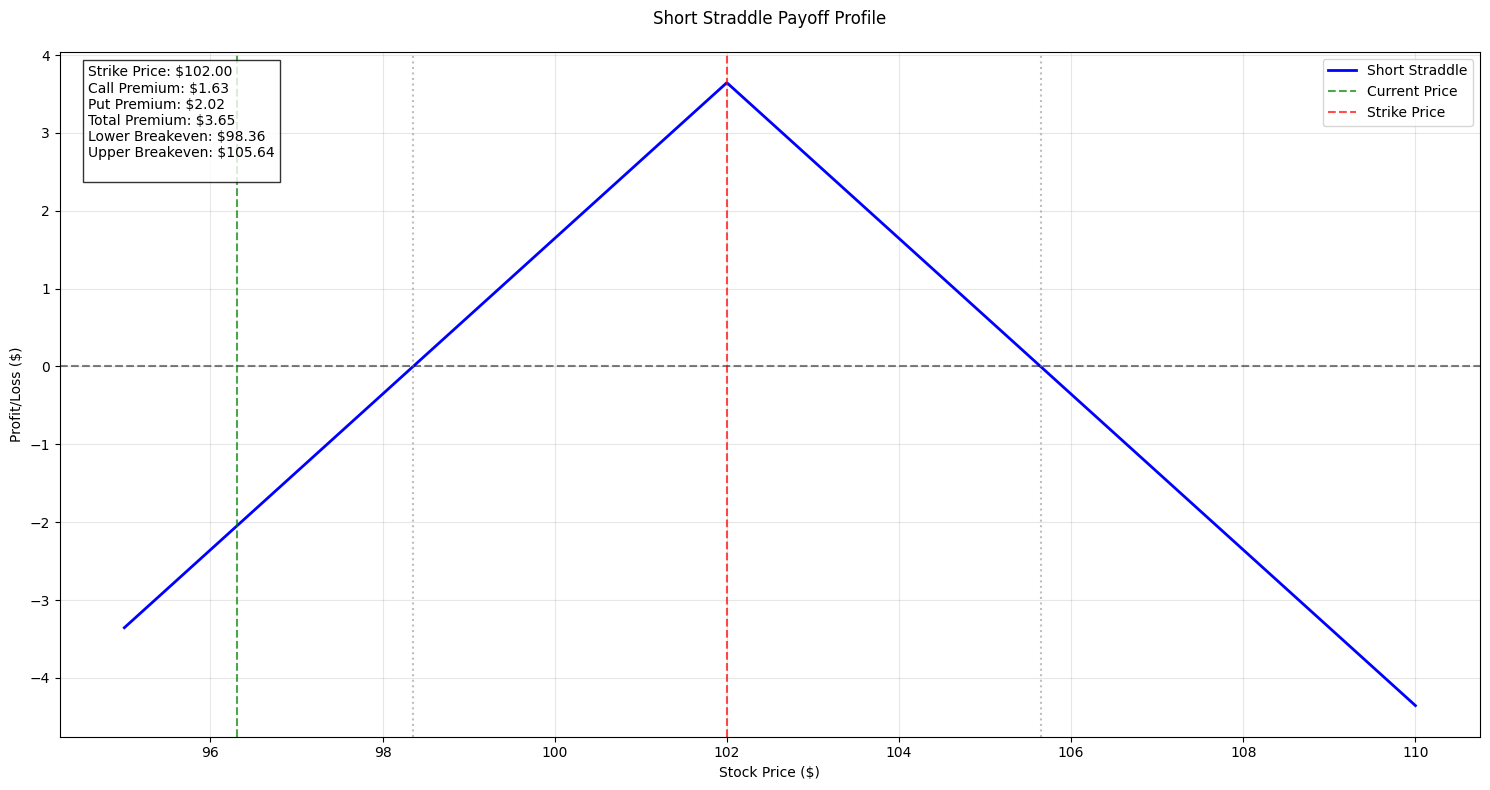


Detailed Short Straddle Analysis:
Sell 1 102.0 Call @ $1.63
Sell 1 102.0 Put @ $2.02
Total Premium Received: $3.65

Break-even Points:
Lower Break-even: $98.36
Upper Break-even: $105.64

Potential Returns:
Maximum Profit: $3.65 (if stock price = strike at expiration)
Maximum Loss: Unlimited (if stock price moves significantly away from strike)

Strategy Characteristics:
1. Benefits from low volatility and minimal price movement.
2. Maximum profit occurs if stock closes at strike price.
3. Unlimited risk if stock price moves significantly in either direction.
4. Time decay works in favor of the position.


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_short_straddle(current_price=96.31):
    """Analyze short straddle strategy and its characteristics"""
    
    # ATM strike
    strike = 102.0
    
    # Updated prices from the table
    call_price = 1.63  # Premium received for selling the call
    put_price = 2.015  # Premium received for selling the put
    total_premium = call_price + put_price  # Total premium received
    
    # Break-even points from data
    lower_breakeven = strike - total_premium  # Lower break-even point
    upper_breakeven = strike + total_premium  # Upper break-even point
    
    # Calculate payoff profiles
    spot_range = np.linspace(95, 110, 1000)
    
    short_straddle_payoffs = np.array([
        total_premium - (max(0, s - strike) + max(0, strike - s)) 
        for s in spot_range
    ])
    
    # Plot payoffs with enhanced visualization
    plt.figure(figsize=(15, 8))
    
    # Main payoff line
    plt.plot(spot_range, short_straddle_payoffs, 'b-', label='Short Straddle', linewidth=2)
    
    # Reference lines
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.axvline(x=current_price, color='g', linestyle='--', label='Current Price', alpha=0.7)
    plt.axvline(x=strike, color='r', linestyle='--', label='Strike Price', alpha=0.7)
    
    # Break-even points
    plt.axvline(x=lower_breakeven, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=upper_breakeven, color='gray', linestyle=':', alpha=0.5)
    
    # Formatting
    plt.title('Short Straddle Payoff Profile', fontsize=12, pad=20)
    plt.xlabel('Stock Price ($)', fontsize=10)
    plt.ylabel('Profit/Loss ($)', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add text box with strategy information
    text_info = f'Strike Price: ${strike:.2f}\n'
    text_info += f'Call Premium: ${call_price:.2f}\n'
    text_info += f'Put Premium: ${put_price:.2f}\n'
    text_info += f'Total Premium: ${total_premium:.2f}\n'
    text_info += f'Lower Breakeven: ${lower_breakeven:.2f}\n'
    text_info += f'Upper Breakeven: ${upper_breakeven:.2f}\n'
    
    plt.text(0.02, 0.98, text_info,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\nDetailed Short Straddle Analysis:")
    print(f"Sell 1 {strike} Call @ ${call_price:.2f}")
    print(f"Sell 1 {strike} Put @ ${put_price:.2f}")
    print(f"Total Premium Received: ${total_premium:.2f}")
    
    print("\nBreak-even Points:")
    print(f"Lower Break-even: ${lower_breakeven:.2f}")
    print(f"Upper Break-even: ${upper_breakeven:.2f}")
    
    print("\nPotential Returns:")
    print(f"Maximum Profit: ${total_premium:.2f} (if stock price = strike at expiration)")
    print(f"Maximum Loss: Unlimited (if stock price moves significantly away from strike)")
    
    print("\nStrategy Characteristics:")
    print("1. Benefits from low volatility and minimal price movement.")
    print("2. Maximum profit occurs if stock closes at strike price.")
    print("3. Unlimited risk if stock price moves significantly in either direction.")
    print("4. Time decay works in favor of the position.")

# Run the analysis
analyze_short_straddle()

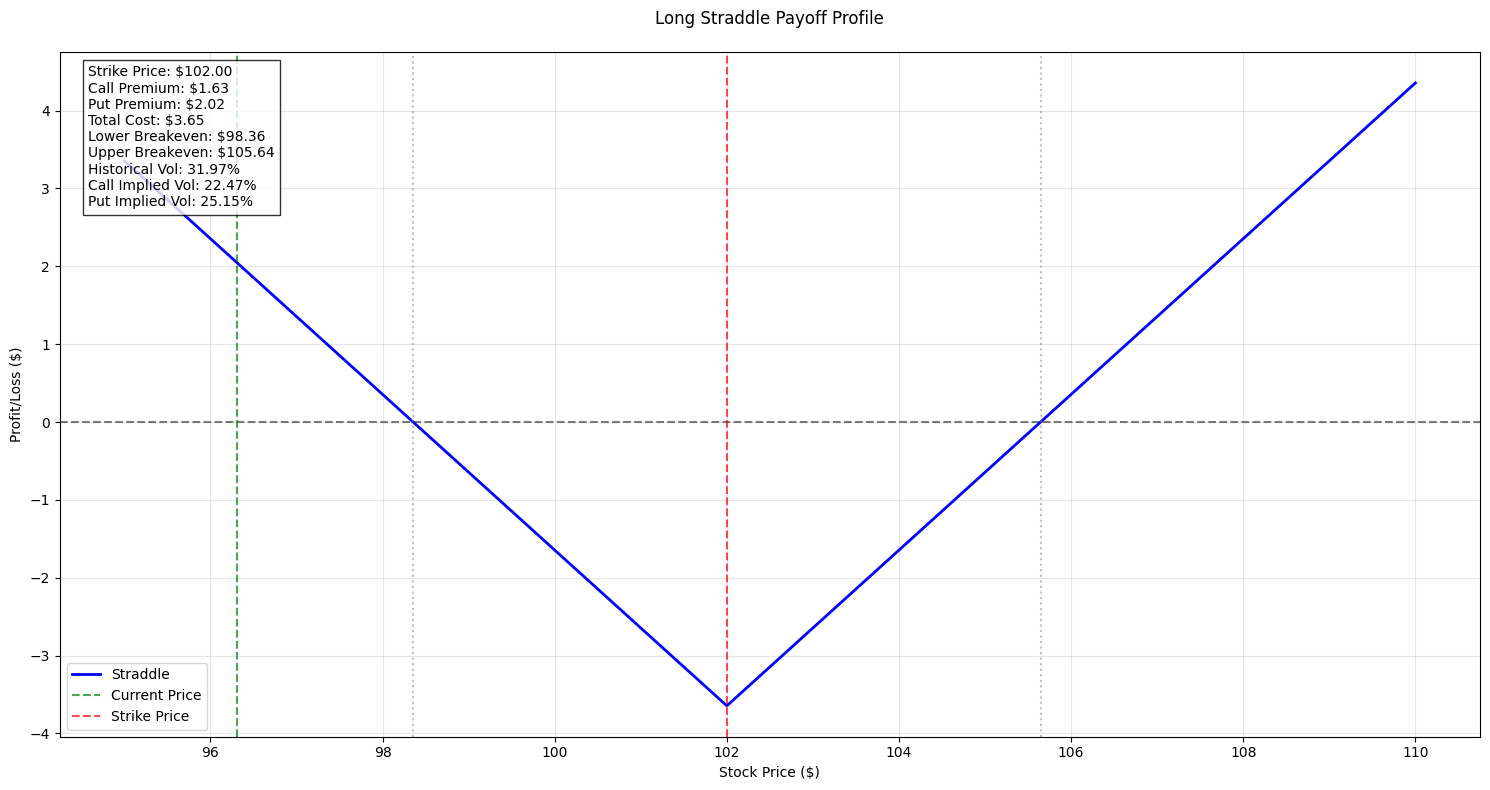


Detailed Straddle Analysis:
Buy 1 102.0 Call @ $1.63
Buy 1 102.0 Put @ $2.02
Total Cost: $3.65

Break-even Points:
Lower Break-even: $98.36
Upper Break-even: $105.64

Volatility Information:
Historical Volatility: 31.97%
Call Implied Volatility: 22.47%
Put Implied Volatility: 25.15%

Potential Returns:
Maximum Loss: $3.65 (if stock price = strike at expiration)
Unlimited Profit Potential above $105.64 or below $98.36

Strategy Characteristics:
1. Benefits from significant price movement in either direction
2. Maximum loss occurs if stock closes at strike price
3. Profits from increased volatility
4. Time decay works against position


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_short_straddle(current_price=96.31):
    """Analyze short straddle strategy and its characteristics"""
    
    # ATM strike
    strike = 102.0
    
    # Updated prices from the table
    call_price = 1.63  # Premium received for selling the call
    put_price = 2.015  # Premium received for selling the put
    total_premium = call_price + put_price  # Total premium received
    
    # Break-even points from data
    lower_breakeven = strike - total_premium  # Lower break-even point
    upper_breakeven = strike + total_premium  # Upper break-even point
    
    # Calculate payoff profiles
    spot_range = np.linspace(95, 110, 1000)
    
    short_straddle_payoffs = np.array([
        total_premium - (max(0, s - strike) + max(0, strike - s)) 
        for s in spot_range
    ])
    
    # Plot payoffs with enhanced visualization
    plt.figure(figsize=(15, 8))
    
    # Main payoff line
    plt.plot(spot_range, short_straddle_payoffs, 'b-', label='Short Straddle', linewidth=2)
    
    # Reference lines
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.axvline(x=current_price, color='g', linestyle='--', label='Current Price', alpha=0.7)
    plt.axvline(x=strike, color='r', linestyle='--', label='Strike Price', alpha=0.7)
    
    # Break-even points
    plt.axvline(x=lower_breakeven, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=upper_breakeven, color='gray', linestyle=':', alpha=0.5)
    
    # Formatting
    plt.title('Short Straddle Payoff Profile', fontsize=12, pad=20)
    plt.xlabel('Stock Price ($)', fontsize=10)
    plt.ylabel('Profit/Loss ($)', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add text box with strategy information
    text_info = f'Strike Price: ${strike:.2f}\n'
    text_info += f'Call Premium: ${call_price:.2f}\n'
    text_info += f'Put Premium: ${put_price:.2f}\n'
    text_info += f'Total Premium: ${total_premium:.2f}\n'
    text_info += f'Lower Breakeven: ${lower_breakeven:.2f}\n'
    text_info += f'Upper Breakeven: ${upper_breakeven:.2f}\n'
    
    plt.text(0.02, 0.98, text_info,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\nDetailed Short Straddle Analysis:")
    print(f"Sell 1 {strike} Call @ ${call_price:.2f}")
    print(f"Sell 1 {strike} Put @ ${put_price:.2f}")
    print(f"Total Premium Received: ${total_premium:.2f}")
    
    print("\nBreak-even Points:")
    print(f"Lower Break-even: ${lower_breakeven:.2f}")
    print(f"Upper Break-even: ${upper_breakeven:.2f}")
    
    print("\nPotential Returns:")
    print(f"Maximum Profit: ${total_premium:.2f} (if stock price = strike at expiration)")
    print(f"Maximum Loss: Unlimited (if stock price moves significantly away from strike)")
    
    print("\nStrategy Characteristics:")
    print("1. Benefits from low volatility and minimal price movement.")
    print("2. Maximum profit occurs if stock closes at strike price.")
    print("3. Unlimited risk if stock price moves significantly in either direction.")
    print("4. Time decay works in favor of the position.")

# Run the analysis
analyze_short_straddle()